# W207 Group Project: True vs Fake News 
#### Members: Akiko Iwamizu, Allison Fox, Jason Yang, Rohin Chabra

In [1]:
# Load libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

import time
import re
import string
import nltk

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from textblob import TextBlob

## Import Data 

In [2]:
# Read in fake news data file.
fake_zip = zipfile.ZipFile("input/fake-and-real-news-dataset/Fake.csv.zip") 
fake = pd.read_csv(fake_zip.open("Fake.csv"))
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
# Read in true news data file.
true_zip = zipfile.ZipFile("input/fake-and-real-news-dataset/True.csv.zip") 
true = pd.read_csv(true_zip.open("True.csv"))
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
# Create label columns for the fake news data set.
fake["label"] = "false"
fake["label_bin"] = 0
fake.shape

(23481, 6)

In [5]:
# Create label columns for the true news data set.
true["label"] = "true"
true["label_bin"] = 1
true.shape

(21417, 6)

In [6]:
# Merge + combine data sets into one.
data = [fake, true]
df = pd.concat(data, ignore_index=True)
df.shape

(44898, 6)

## Clean & Process Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   label      44898 non-null  object
 5   label_bin  44898 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [8]:
# Confirm the population of each column.
print(f"Null records:\n{df.isna().sum()}\n")
print(f"Empty text records: {len(df[df['text'] == ' '])}\n")
print(f"Empty title records: {len(df[df['title'] == ''])}")

Null records:
title        0
text         0
subject      0
date         0
label        0
label_bin    0
dtype: int64

Empty text records: 627

Empty title records: 0


In [9]:
# Find & remove records where the cleaned text or title column values are empty or NULL.
print(f"Number of text records with a URL: {df['text'].str.count('http|www').sum()}")
print(f"Number of title records with a URL: {df['title'].str.count('http|www').sum()}")
print(f"Number of date records with a URL: {df['date'].str.count('http|www').sum()}")

Number of text records with a URL: 5492
Number of title records with a URL: 9
Number of date records with a URL: 9


In [10]:
# Find records where date column values are invalid.
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
print(f"Number of invalid date records: {len(df.loc[df['date'].isnull()])}")
df.loc[df['date'].isnull()].head(20)

Number of invalid date records: 10


,title,text,subject,date,label,label_bin
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT,false,0
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,NaT,false,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,NaT,false,0
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,false,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,false,0
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,false,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,false,0
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,NaT,false,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,false,0
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,false,0


In [11]:
# Remove records where date column values are invalid.
df = df.dropna(subset=["date"])
df.shape

(44888, 6)

In [12]:
df["date"].describe()

count          44888
unique          1010
top       2017-12-20
freq             197
Name: date, dtype: object

In [13]:
# Function for cleaning text inputs.
def preprocess_text(text):
    """Use regex and other tools for pre-processing of the text."""
    # Apply lowercasing.
    text = text.lower()
    
    # Replace stop words with empty strings.
    pattern = re.compile(r"\b(" + r"|".join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub("", text)
    
    # Replace punctuation with empty strings.
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    
    # Replace all non-alphanumeric characters with a single space.
    text = re.sub(r"[^a-z0-9]+", " ", text)
    
    # Replace large, consecutive amounts of whitespace with a single space.
    text = re.sub(r"[\s]+", " ", text)
    
    # Remove leading and trailing whitespace.
    text = text.strip()
    
    return text

In [14]:
# Clean up text features.
nltk.download("stopwords")

start_time = time.time()
stop_words = set(stopwords.words("english"))

df["clean_title"] = df["title"].apply(lambda text: preprocess_text(text))
df["clean_text"] = df["text"].apply(lambda text: preprocess_text(text))

print(f"{(time.time() - start_time):0.3f} seconds to execute pre-processing text inputs...")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akikoiwamizu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


31.559 seconds to execute pre-processing text inputs...


In [15]:
df.head()

,title,text,subject,date,label,label_bin,clean_title,clean_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,false,0,donald trump sends embarrassing new year eve m...,donald trump wish americans happy new year lea...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,false,0,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,false,0,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,false,0,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,false,0,pope francis called donald trump christmas speech,pope francis used annual christmas day message...


In [16]:
df["clean_text"].describe()

count     44888
unique    38363
top            
freq        632
Name: clean_text, dtype: object

In [17]:
df["clean_title"].describe()

count                                           44888
unique                                          38709
top       factbox trump fills top jobs administration
freq                                               14
Name: clean_title, dtype: object

In [18]:
print(f"Empty clean text records: {len(df[df['clean_text'] == ''])}")
df[df["clean_text"] == ""].head()

Empty clean text records: 632


,title,text,subject,date,label,label_bin,clean_title,clean_text
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,2017-05-10,false,0,take poll think president trump pick replace j...,
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,2017-04-26,false,0,joe scarborough berates mika brzezinski cheap ...,
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,2017-04-06,false,0,watch tucker carlson scorch sanctuary city may...,
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,2017-04-02,false,0,mayor sanctuary city trump trying make us fugi...,
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,2017-04-01,false,0,shocker public school turns computer lab mosqu...,


In [19]:
print(f"Empty clean title records: {len(df[df['clean_title'] == ''])}")
df[df["clean_title"] == ""].head()

Empty clean title records: 0


,title,text,subject,date,label,label_bin,clean_title,clean_text


### QUESTION: Should we remove records without text?

## Split Train, Test, & Dev Data

In [20]:
# Split data sets into train (70%), test (15%), & dev (15%).
# Use random_state param to reproduce shuffle outcomes.
train, test = train_test_split(df, random_state=0, train_size=0.7, test_size=0.3, shuffle=True)
num_test = int(len(test)/2)
test = test[num_test:]
dev = test[:num_test]

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
print("Dev data shape:", dev.shape)

Train data shape: (31421, 8)
Test data shape: (6734, 8)
Dev data shape: (6733, 8)


In [21]:
# Export train, test, & dev data sets to dir.
# Write a Pandas DataFrame as a zipped CSV file.
#train.to_csv("input/processed-datasets/train.csv", index=False)
#test.to_csv("input/processed-datasets/test.csv", index=False)
#dev.to_csv("input/processed-datasets/dev.csv", index=False)

## Exploratory Data Analysis

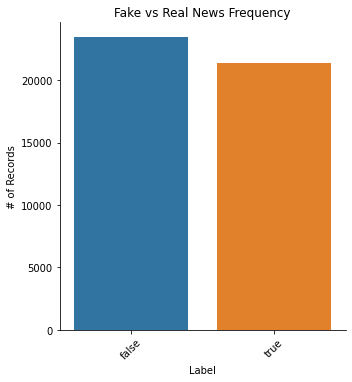

In [22]:
# Histograms looking at the distribution of fake vs real news labels.
g = sns.catplot(data=df, x="label", kind="count")
g.set(xlabel="Label", ylabel="# of Records", title="Fake vs Real News Frequency")
g.set_xticklabels(rotation=45)

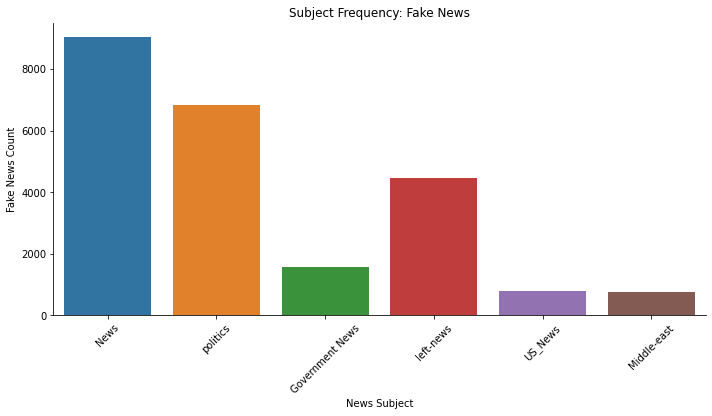

In [23]:
# Histogram looking at the frequency of fake news subjects.
g = sns.catplot(data=fake, x="subject", col="label_bin", kind="count", aspect=2)
g.set(xlabel="News Subject", ylabel="Fake News Count", title="Subject Frequency: Fake News")
g.set_xticklabels(rotation=45)

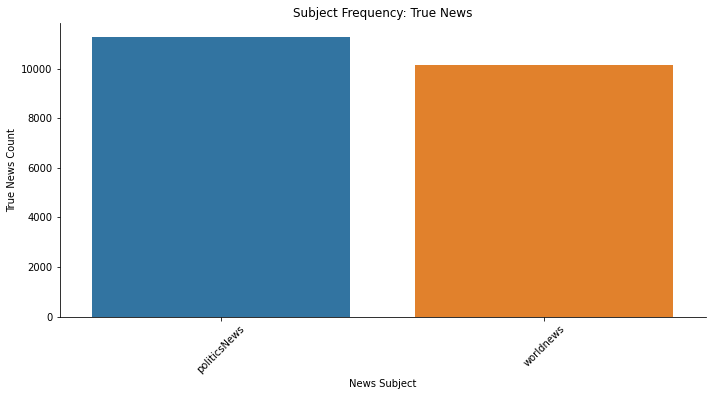

In [24]:
# Histogram looking at the frequency of true news subjects.
g = sns.catplot(data=true, x="subject", col="label_bin", kind="count", aspect=2)
g.set(xlabel="News Subject", ylabel="True News Count", title="Subject Frequency: True News")
g.set_xticklabels(rotation=45)

### QUESTION: Should we be concerned that there is no overlap in subjects between fake vs true news?

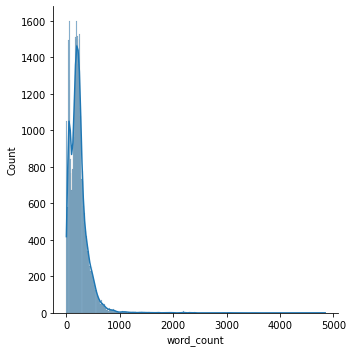

In [35]:
# Distribution of the word count of the clean text values of the news data.
df["word_count"] = df["clean_text"].apply(lambda x: len(str(x).split()))
sns.displot(df["word_count"], kde=True)
fig = plt.gcf()

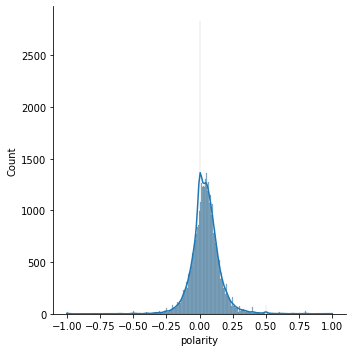

In [34]:
# Distribution of the polarity of the clean text values of the news data. Appears to be neutral on average.
df["polarity"] = df["clean_text"].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(df["polarity"], kde=True)
fig = plt.gcf()